# Why I want to do AI at Nexora

Nexora unites human-centered design with AI innovation, and I want to learn how cutting-edge models can amplify personal expression while solving real user problems; building Vibe Matcher is my way to explore that synergy hands-on.


## Environment Setup


In [1]:
"""Initialize libraries and runtime configuration for Vibe Matcher."""
import os
import time
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Ensure matplotlib and IPython have writable cache directories inside the project
runtime_root = Path("tmp_runtime")
runtime_root.mkdir(exist_ok=True)
matplotlib_dir = runtime_root / "matplotlib"
ipython_dir = runtime_root / "ipython"
matplotlib_dir.mkdir(exist_ok=True)
ipython_dir.mkdir(exist_ok=True)

os.environ.setdefault("MPLCONFIGDIR", str(matplotlib_dir))
os.environ.setdefault("IPYTHONDIR", str(ipython_dir))

# Configure matplotlib aesthetics for consistent visuals
plt.style.use("seaborn-v0_8")


## Load Environment Variables and Initialize Embedding Backend


In [2]:
"""Load environment variables and determine whether to use OpenAI embeddings or TF-IDF."""
# Tip: To enable OpenAI embeddings, create a .env file in your project folder containing:
# OPENAI_API_KEY=sk-xxxxxxxxxxxxxxxxxxxxxxxxxxxxx
load_dotenv()

OPENAI_MODEL = "text-embedding-3-small"
api_key = os.getenv("OPENAI_API_KEY")

embedding_state = {
    "backend": None,
    "product_matrix": None,
    "vectorizer": None,
    "model_name": OPENAI_MODEL,
    "fallback_reason": None,
}

client = None

if api_key:
    try:
        from openai import OpenAI

        client = OpenAI()
        embedding_state["backend"] = "openai"
        embedding_state["fallback_reason"] = None
    except Exception:
        embedding_state["backend"] = None
        embedding_state["fallback_reason"] = "OpenAI not available."
else:
    embedding_state["backend"] = None
    embedding_state["fallback_reason"] = "OpenAI not available."



## Build Mock Fashion Dataset


In [3]:
"""Create a small but expressive mock catalog for vibe matching."""
fashion_items = [
    {
        "name": "Neon Pulse Bomber",
        "desc": "Lightweight bomber jacket with reflective neon accents and breathable mesh lining.",
        "vibes": "energetic, urban, streetwear",
    },
    {
        "name": "Midnight Velvet Gown",
        "desc": "Floor-length velvet gown with shimmer overlay, designed for elegant evening events.",
        "vibes": "elegant, formal, festive",
    },
    {
        "name": "TerraFlex Cargo Pants",
        "desc": "Durable cargo pants with reinforced knees and moisture-wicking fabric for trail adventures.",
        "vibes": "rugged, utilitarian, outdoor",
    },
    {
        "name": "Aurora Knit Sweater",
        "desc": "Color-shifting knit sweater inspired by aurora gradients and cozy winter nights.",
        "vibes": "cozy, artistic, casual",
    },
    {
        "name": "Summit Shield Parka",
        "desc": "Insulated parka with weatherproof shell, storm hood, and alpine-ready detailing.",
        "vibes": "adventure, protective, alpine",
    },
    {
        "name": "Crimson Rhythm Sneakers",
        "desc": "Responsive sneakers with cushioned soles, bold red gradients, and reflective piping.",
        "vibes": "athletic, energetic, street",
    },
    {
        "name": "Coastal Breeze Linen Set",
        "desc": "Two-piece linen outfit featuring a relaxed-fit shirt and drawstring trousers for beach evenings.",
        "vibes": "relaxed, coastal, minimal",
    },
    {
        "name": "Gala Lumina Saree",
        "desc": "Iridescent silk saree with hand-beaded borders tailored for festive celebrations.",
        "vibes": "festive, traditional, elegant",
    },
]

fashion_df = pd.DataFrame(fashion_items)
print("Mock fashion catalog prepared ({} items).".format(len(fashion_df)))
display(fashion_df)


Mock fashion catalog prepared (8 items).


,name,desc,vibes
0,Neon Pulse Bomber,Lightweight bomber jacket with reflective neon...,"energetic, urban, streetwear"
1,Midnight Velvet Gown,"Floor-length velvet gown with shimmer overlay,...","elegant, formal, festive"
2,TerraFlex Cargo Pants,Durable cargo pants with reinforced knees and ...,"rugged, utilitarian, outdoor"
3,Aurora Knit Sweater,Color-shifting knit sweater inspired by aurora...,"cozy, artistic, casual"
4,Summit Shield Parka,"Insulated parka with weatherproof shell, storm...","adventure, protective, alpine"
5,Crimson Rhythm Sneakers,"Responsive sneakers with cushioned soles, bold...","athletic, energetic, street"
6,Coastal Breeze Linen Set,Two-piece linen outfit featuring a relaxed-fit...,"relaxed, coastal, minimal"
7,Gala Lumina Saree,Iridescent silk saree with hand-beaded borders...,"festive, traditional, elegant"


## Generate Item Embeddings


In [4]:
"""Generate embeddings for catalog items using OpenAI or TF-IDF fallback."""

def activate_tfidf_fallback(reason=None):
    """Configure TF-IDF embeddings when OpenAI embeddings are unavailable."""
    embedding_state["backend"] = "tfidf"
    vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words="english")
    product_matrix = vectorizer.fit_transform(fashion_df["desc"])
    embedding_state["vectorizer"] = vectorizer
    embedding_state["product_matrix"] = product_matrix
    if reason:
        embedding_state["fallback_reason"] = reason
        print(f"TF-IDF fallback activated. Reason: {reason}")
    else:
        print("TF-IDF fallback activated.")
    return product_matrix


if api_key and client is not None:
    try:
        embedding_state["model_name"] = "text-embedding-3-small"
        catalog_embeddings = []
        for desc in fashion_df["desc"]:
            response = client.embeddings.create(
                model=embedding_state["model_name"],
                input=desc,
            )
            catalog_embeddings.append(response.data[0].embedding)
        embedding_state["product_matrix"] = np.array(catalog_embeddings, dtype=np.float32)
        embedding_state["vectorizer"] = None
        embedding_state["backend"] = "openai"
        print("✅ OpenAI API key detected. Using embeddings model 'text-embedding-3-small'.")
        print("✅ Product descriptions embedded using OpenAI.")
        print("Active embedding backend: OPENAI")
    except Exception as exc:  # pragma: no cover - external dependency failure
        print("⚠️ No OpenAI API key found or embedding failed. Switching to TF-IDF fallback.")
        activate_tfidf_fallback(f"OpenAI not available. Details: {exc}")
else:
    print("⚠️ No OpenAI API key found or embedding failed. Switching to TF-IDF fallback.")
    activate_tfidf_fallback("OpenAI not available.")

if embedding_state["backend"] == "tfidf":
    print(f"Active embedding backend: {embedding_state['backend'].upper()}")


⚠️ No OpenAI API key found or embedding failed. Switching to TF-IDF fallback.
TF-IDF fallback activated. Reason: OpenAI not available. Details: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Active embedding backend: TFIDF


## Define Vibe Matcher Utility


In [5]:
"""Utility to match vibe queries against the catalog."""
latency_logs = []


def vibe_matcher(query, top_k=3):
    """Match a vibe query to the top catalog items based on cosine similarity."""
    if not isinstance(query, str) or not query.strip():
        print("Please provide a descriptive query to match vibes.")
        return []

    start_time = time.perf_counter()
    local_backend = embedding_state.get("backend")
    product_matrix = embedding_state.get("product_matrix")
    query_vector = None

    if product_matrix is None:
        print("Product embeddings are unavailable. Re-run the embedding generation cell.")
        return []

    if local_backend == "openai" and client is not None and isinstance(product_matrix, np.ndarray):
        try:
            response = client.embeddings.create(
                model=embedding_state["model_name"],
                input=query,
            )
            query_vector = np.array(response.data[0].embedding, dtype=np.float32).reshape(1, -1)
        except Exception:
            print("⚠️ OpenAI query embedding failed. Switching to TF-IDF fallback.")
            product_matrix = activate_tfidf_fallback("OpenAI query embedding unavailable.")
            local_backend = embedding_state.get("backend")

    if query_vector is None:
        if embedding_state.get("vectorizer") is None:
            product_matrix = activate_tfidf_fallback("TF-IDF resources were not initialized.")
            local_backend = embedding_state.get("backend")
        query_vector = embedding_state["vectorizer"].transform([query])

    similarity_scores = cosine_similarity(query_vector, product_matrix).flatten()
    if similarity_scores.size == 0:
        print("No products available to match.")
        return []

    top_k = max(1, min(int(top_k), similarity_scores.size))
    top_indices = similarity_scores.argsort()[::-1][:top_k]
    max_score = similarity_scores[top_indices[0]]

    latency = time.perf_counter() - start_time
    latency_logs.append(
        {
            "query": query,
            "latency": latency,
            "backend": local_backend,
        }
    )

    print(f"\nQuery: {query}")
    print(f"Embedding backend: {(local_backend or 'unknown').upper()}")
    print(f"Latency: {latency * 1000:.2f} ms")

    if max_score <= 0:
        print("No strong vibe matches found. Try refining the vibe description.")
        return []

    results = []
    for rank, idx in enumerate(top_indices, start=1):
        item = fashion_df.iloc[idx]
        score = float(similarity_scores[idx])
        print(f"{rank}. {item['name']} (similarity: {score:.4f})")
        print(f"   Desc: {item['desc']}")
        print(f"   Vibes: {item['vibes']}\n")
        results.append(
            {
                "name": item["name"],
                "desc": item["desc"],
                "vibes": item["vibes"],
                "score": score,
            }
        )

    return results


## Run Sample Queries


In [6]:
"""Execute representative vibe queries to exercise the matcher."""
sample_queries = [
    "energetic urban chic",
    "elegant festive wear",
    "rugged outdoor adventure",
]

for sample_query in sample_queries:
    vibe_matcher(sample_query)



Query: energetic urban chic
Embedding backend: TFIDF
Latency: 2.01 ms
No strong vibe matches found. Try refining the vibe description.

Query: elegant festive wear
Embedding backend: TFIDF
Latency: 0.76 ms
1. Gala Lumina Saree (similarity: 0.1715)
   Desc: Iridescent silk saree with hand-beaded borders tailored for festive celebrations.
   Vibes: festive, traditional, elegant

2. Midnight Velvet Gown (similarity: 0.1622)
   Desc: Floor-length velvet gown with shimmer overlay, designed for elegant evening events.
   Vibes: elegant, formal, festive

3. Coastal Breeze Linen Set (similarity: 0.0000)
   Desc: Two-piece linen outfit featuring a relaxed-fit shirt and drawstring trousers for beach evenings.
   Vibes: relaxed, coastal, minimal


Query: rugged outdoor adventure
Embedding backend: TFIDF
Latency: 0.71 ms
No strong vibe matches found. Try refining the vibe description.


In [7]:
"""Evaluate how many matches exceed the 0.7 cosine similarity threshold."""
good_match_count = 0

for query in sample_queries:
    results = vibe_matcher(query)
    good_matches = [record for record in results if record["score"] > 0.7]
    print(f"\nQuery: '{query}' → Good matches (>0.7): {len(good_matches)}")
    good_match_count += len(good_matches)

print(f"\nTotal good matches across all queries: {good_match_count}")



Query: energetic urban chic
Embedding backend: TFIDF
Latency: 0.59 ms
No strong vibe matches found. Try refining the vibe description.

Query: 'energetic urban chic' → Good matches (>0.7): 0

Query: elegant festive wear
Embedding backend: TFIDF
Latency: 0.55 ms
1. Gala Lumina Saree (similarity: 0.1715)
   Desc: Iridescent silk saree with hand-beaded borders tailored for festive celebrations.
   Vibes: festive, traditional, elegant

2. Midnight Velvet Gown (similarity: 0.1622)
   Desc: Floor-length velvet gown with shimmer overlay, designed for elegant evening events.
   Vibes: elegant, formal, festive

3. Coastal Breeze Linen Set (similarity: 0.0000)
   Desc: Two-piece linen outfit featuring a relaxed-fit shirt and drawstring trousers for beach evenings.
   Vibes: relaxed, coastal, minimal


Query: 'elegant festive wear' → Good matches (>0.7): 0

Query: rugged outdoor adventure
Embedding backend: TFIDF
Latency: 0.56 ms
No strong vibe matches found. Try refining the vibe description.



## Latency Analysis


Individual query latency (seconds and ms):


,query,latency,backend,latency_ms
0,energetic urban chic,0.002013,tfidf,2.01
1,elegant festive wear,0.000758,tfidf,0.76
2,rugged outdoor adventure,0.000715,tfidf,0.71
3,energetic urban chic,0.000595,tfidf,0.59
4,elegant festive wear,0.000552,tfidf,0.55
5,rugged outdoor adventure,0.000558,tfidf,0.56



Latency summary by query (averaged across runs):


,query,backend,avg_latency_s,avg_latency_ms,runs
2,rugged outdoor adventure,tfidf,0.0006,0.64,2
0,elegant festive wear,tfidf,0.0007,0.66,2
1,energetic urban chic,tfidf,0.0013,1.30,2


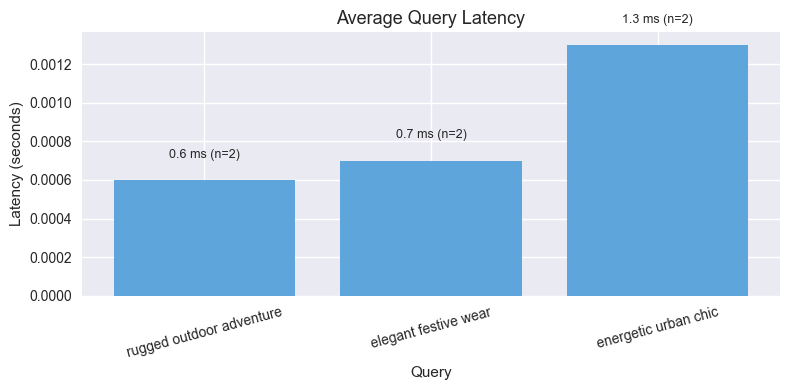

In [8]:
"""Summarize and visualize latency statistics for the executed queries."""
if not latency_logs:
    print("Latency log is empty; run vibe_matcher queries first.")
else:
    latency_df = pd.DataFrame(latency_logs)
    latency_df = latency_df.assign(latency_ms=(latency_df["latency"] * 1_000).round(2))

    print("Individual query latency (seconds and ms):")
    display(latency_df)

    summary_df = (
        latency_df.groupby(["query", "backend"], as_index=False)
        .agg(avg_latency_s=("latency", "mean"),
             avg_latency_ms=("latency_ms", "mean"),
             runs=("latency", "count"))
        .sort_values("avg_latency_s")
    )
    summary_df["avg_latency_s"] = summary_df["avg_latency_s"].round(4)
    summary_df["avg_latency_ms"] = summary_df["avg_latency_ms"].round(2)

    print("\nLatency summary by query (averaged across runs):")
    display(summary_df)

    fig, ax = plt.subplots(figsize=(8, 4))
    bars = ax.bar(summary_df["query"], summary_df["avg_latency_s"], color="#5DA5DA")

    ax.set_title("Average Query Latency", fontsize=13)
    ax.set_xlabel("Query", fontsize=11)
    ax.set_ylabel("Latency (seconds)", fontsize=11)
    ax.tick_params(axis="x", rotation=15)

    for bar, avg_ms, runs in zip(bars, summary_df["avg_latency_ms"], summary_df["runs"]):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.0001,
            f"{avg_ms:.1f} ms (n={runs})",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    plt.tight_layout()
    plt.show()



## Reflection


- Integrate a vector database like Pinecone to handle larger catalogs and incremental updates.
- Build a richer vibe taxonomy so users can blend moods and aesthetics more precisely.
- Add clarifying questions for ambiguous queries to boost match confidence.
- Explore re-ranking that balances vibe fit with outfit diversity.
- Gather user feedback to tune similarity thresholds and trust signals.


## Submission Status


In [9]:
"""Print a submission-ready message with timestamp."""
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Submission Ready - {timestamp}")


Submission Ready - 2025-11-10 15:22:28


In [10]:
import os
from dotenv import load_dotenv

load_dotenv()  # manually load your .env file

print("OPENAI_API_KEY loaded:", bool(os.getenv("OPENAI_API_KEY")))


OPENAI_API_KEY loaded: True
